In [1]:
import jax
import jax.numpy as jnp
import jax.tree_util as jtu

import equinox as eqx
import optax
import einops
import matplotlib
import matplotlib.pyplot as plt
import ipdb
import tqdm.notebook as tqdm
import pprint

import infomec
import importlib
importlib.reload(infomec)
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [2]:
INPUT_SIZE = 3
HIDDEN_SIZE = 256
SOURCE_SIZE = 3
LATENT_SIZE = 6
NUM_LAYERS = 6

def generate_data():
    s = jax.random.uniform(jax.random.PRNGKey(0), (10000, INPUT_SIZE), minval=0, maxval=1)
    
    # g = eqx.nn.MLP(SOURCE_SIZE, INPUT_SIZE, 64, 2, jnp.tanh, key=jax.random.PRNGKey(1))
    # x = jax.vmap(g)(s)
    # standardize x
    x = s
    x = (x - x.mean(0)) / x.std(0)
    return dict(x=x, s=s)
    
data = generate_data()

2024-05-09 16:58:35.657673: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.99). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


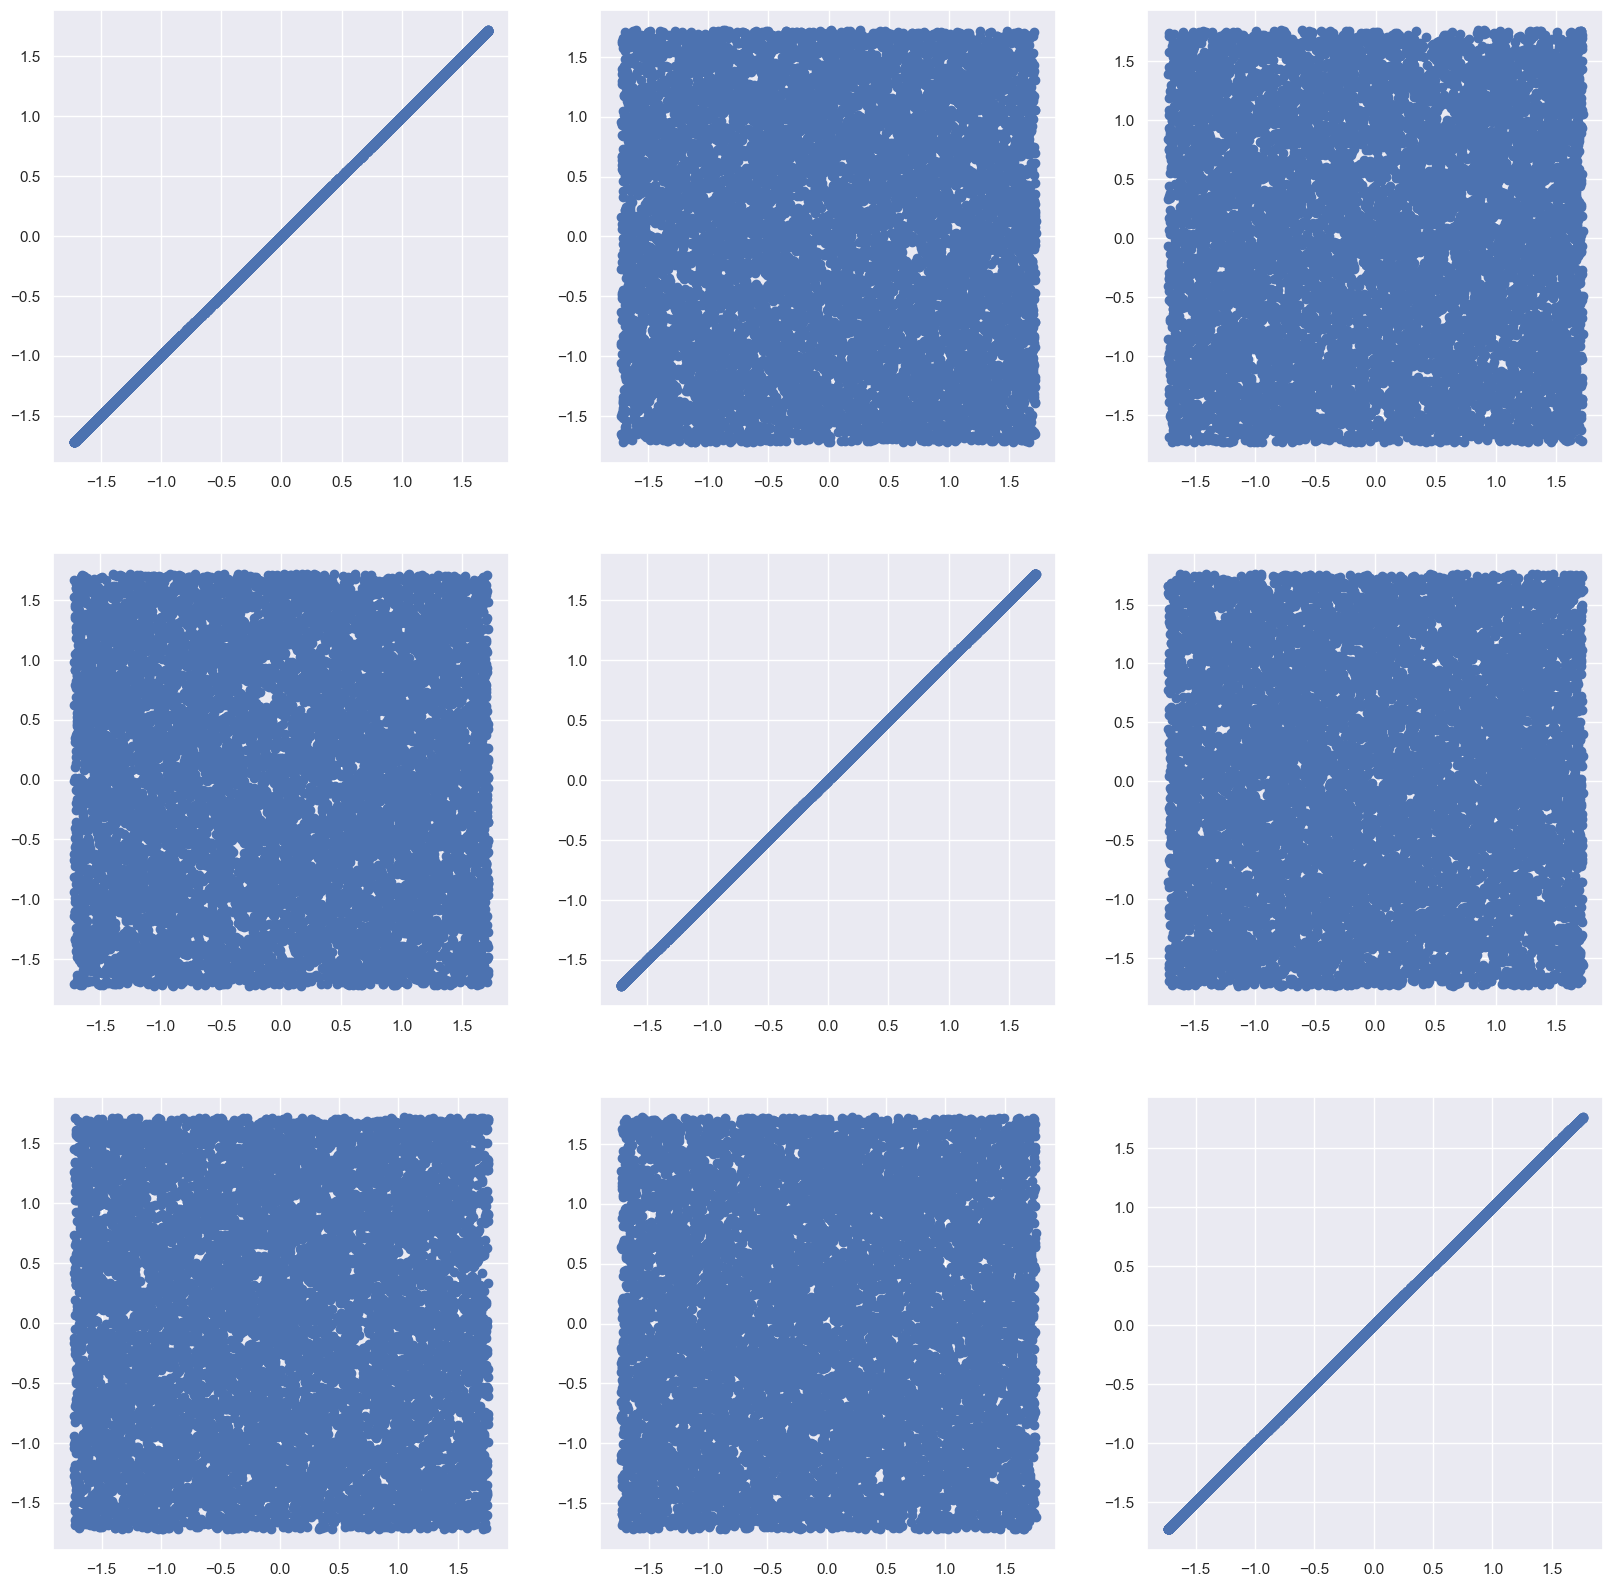

In [3]:
fig, axes = plt.subplots(INPUT_SIZE, INPUT_SIZE, figsize=(20, 20))
for i in range(INPUT_SIZE):
    for j in range(INPUT_SIZE):
        axes[i, j].scatter(data['x'][:, i], data['x'][:, j])

In [4]:
class Model(eqx.Module):
    encoder: eqx.nn.MLP
    decoder: eqx.nn.MLP
    lambdas: dict
    num_params: int
    
    def __init__(self, *, key):
        keys = iter(jax.random.split(key, 100))
        self.encoder = eqx.nn.MLP(INPUT_SIZE, LATENT_SIZE, HIDDEN_SIZE, NUM_LAYERS, jax.nn.relu, key=next(keys))
        self.decoder = eqx.nn.MLP(LATENT_SIZE, INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, jax.nn.relu, key=next(keys))
        self.lambdas = {
            'reconstruction': 1.0,
            'activation_energy': 10,
            'activation_negativity': 10,
            'weight_energy': 1
        }
        self.num_params = sum(x.size for x in jtu.tree_leaves(eqx.filter(self, eqx.is_array)))
    
    def loss(self, model, data, *, key=None):
        x = data['x']
        z = jax.vmap(model.encoder)(x)
        x_hat = jax.vmap(model.decoder)(z)
        losses = {}
        losses['reconstruction'] = einops.reduce((x - x_hat) ** 2, 'n d -> n', 'mean')
        losses['activation_energy'] = einops.reduce(z ** 2, 'n d -> n', 'mean')
        losses['activation_negativity'] = einops.reduce((0.5 * (z - jnp.abs(z))) ** 2, 'n d -> n', 'mean')
        losses['weight_energy'] = Model.l2(model) / model.num_params
        losses['total'] = sum(losses[k] * model.lambdas[k] for k in losses.keys())
        aux = {
            'z': z,
            'x_hat': x_hat,
            'losses': losses
        }
        return jnp.mean(losses['total']), aux
        
    @staticmethod
    def l2(model):
        sum_squares = sum(jnp.sum(x ** 2) for x in jtu.tree_leaves(eqx.filter(model, eqx.is_array)))
        return jnp.sqrt(sum_squares)

@eqx.filter_jit
def train_step(model, optimizer_state, optimizer, data, *, key):
    (_, aux), grad = eqx.filter_value_and_grad(model.loss, has_aux=True)(model, data, key=key)
    update, optimizer_state = optimizer.update(grad, optimizer_state, model)
    model = eqx.apply_updates(model, update)
    return model, optimizer_state, aux
    

In [5]:
key = jax.random.PRNGKey(42)
model = Model(key=key)
optimizer = optax.adamw(learning_rate=1e-3, weight_decay=0)
optimizer_state = optimizer.init(eqx.filter(model, eqx.is_array))
print(model.num_params)

663049


In [ ]:
for _ in tqdm.trange(int(1e6)):
    key, subkey = jax.random.split(key)
    model, optimizer_state, aux = train_step(model, optimizer_state, optimizer, data, key=subkey)
    if _ % 2000 == 0:
        pprint.pprint(
            {k: jnp.mean(v).item() for k, v in aux['losses'].items()}
        )
        
        metrics = infomec.compute_infomec(data['s'], aux['z'], 'continuous', 'continuous')
        pprint.pprint(metrics)

  0%|          | 0/1000000 [00:00<?, ?it/s]

{'activation_energy': 0.00023792505089659244,
 'activation_negativity': 0.0001604894787305966,
 'reconstruction': 1.0017215013504028,
 'total': 1.0057553052902222,
 'weight_energy': 4.955759868607856e-05}
pruned_nmi shape: (3, 6)
{'active_latents': array([ True,  True,  True,  True,  True,  True]),
 'infoc': 0.1942411615345136,
 'infoe': 0.6468778857304459,
 'infom': 0.31495759801396,
 'nmi': array([[0.0254674 , 0.0289018 , 0.11110996, 0.07598639, 0.03907994,
        0.02656421],
       [0.0295412 , 0.01989897, 0.01258776, 0.01162864, 0.06129732,
        0.09292593],
       [0.04102499, 0.03374374, 0.04380327, 0.03365131, 0.03013502,
        0.02041047]])}
{'activation_energy': 0.0005124020972289145,
 'activation_negativity': 0.00012596489978022873,
 'reconstruction': 0.025386273860931396,
 'total': 0.03181978687644005,
 'weight_energy': 4.9843925808090717e-05}
pruned_nmi shape: (3, 6)
{'active_latents': array([ True,  True,  True,  True,  True,  True]),
 'infoc': 0.14186293076312026,


In [1]:
metrics = infomec.compute_infomec(data['s'], aux['z'], 'continuous', 'continuous')
pprint.pprint(metrics)
sns.heatmap(metrics['nmi'], vmin=0, vmax=1, annot=True)

NameError: name 'infomec' is not defined

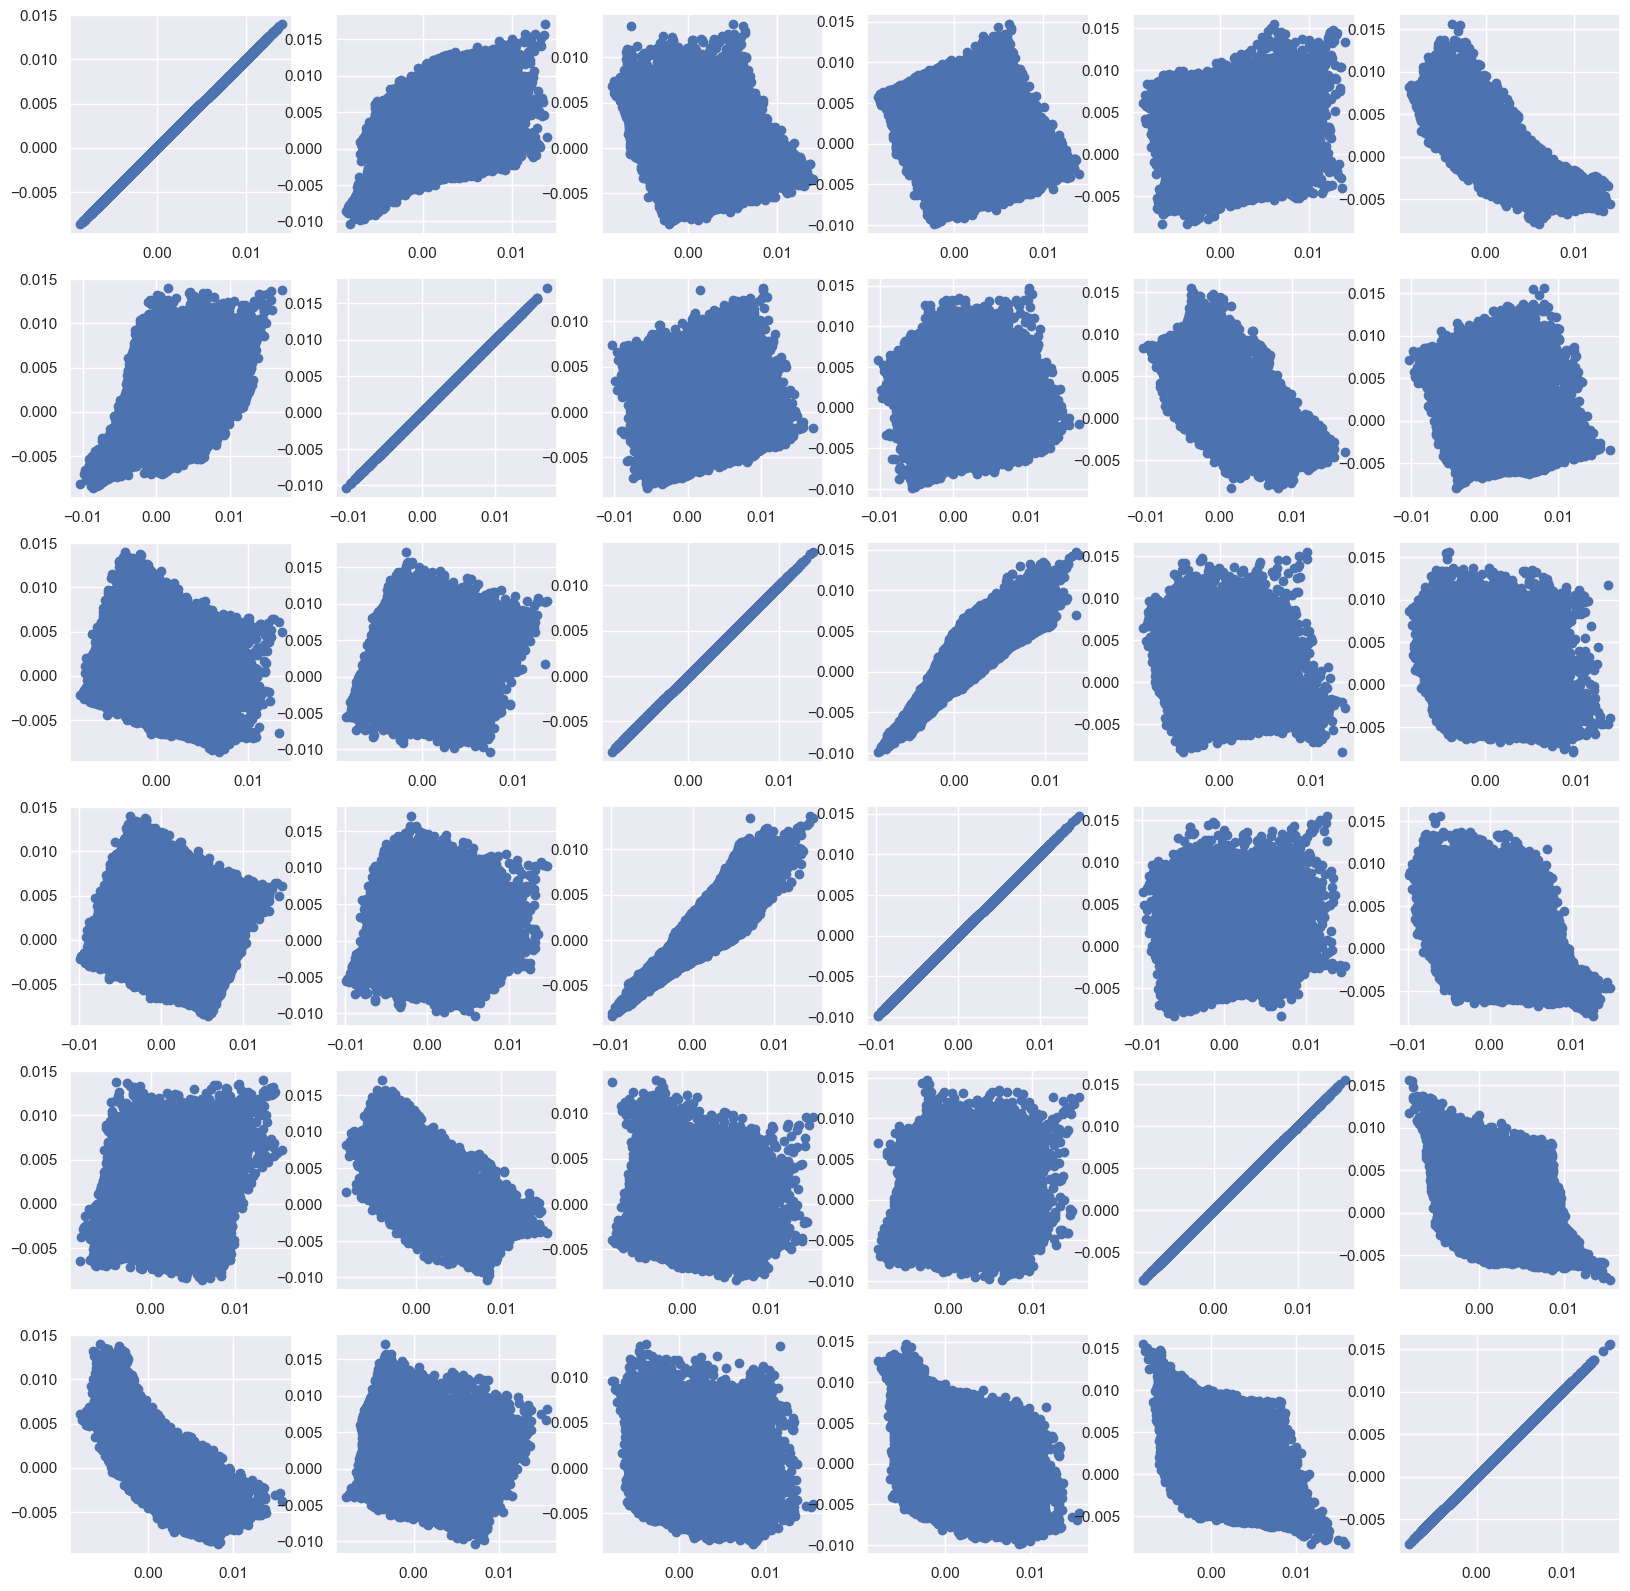

In [18]:
fig, axes = plt.subplots(LATENT_SIZE, LATENT_SIZE, figsize=(20, 20))
for i in range(LATENT_SIZE):
    for j in range(LATENT_SIZE):
        axes[i, j].scatter(aux['z'][:, i], aux['z'][:, j])

<Axes: >

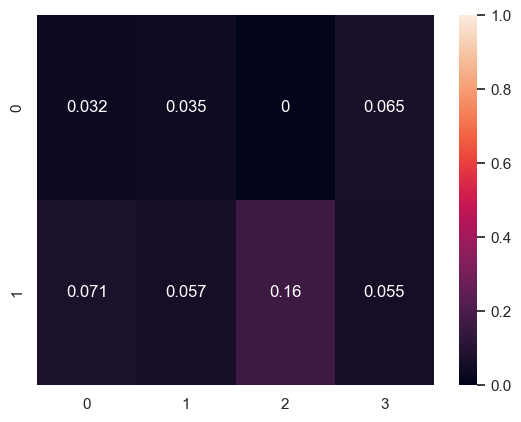

pruned_nmi shape: (2, 4)


<Axes: >

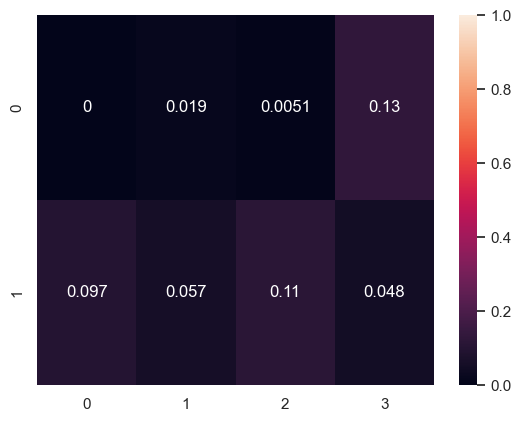

In [55]:
metrics = infomec.compute_infomec(data['s'], aux['z'], False)
sns.heatmap(metrics['nmi'], vmin=0, vmax=1, annot=True)